In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [ ]:
train = pd.read_csv("train.csv")
test =  pd.read_csv("test.csv")

In [ ]:
train.describe()

store           item          sales
count  336694.000000  336694.000000  336694.000000
mean        5.433866       9.726119      54.676570
std         2.876138       5.326639      30.292561
min         1.000000       1.000000       0.000000
25%         3.000000       5.000000      30.000000
50%         5.000000      10.000000      50.000000
75%         8.000000      14.000000      74.000000
max        10.000000      19.000000     231.000000

In [ ]:
print('Min date from test set: %s' % train['date'].min())
print('Max date from test set: %s' % train['date'].max())
import datetime
lag_size = len(test['date'].unique())
print('Forecast lag size: ', lag_size)

Min date from test set: 20
Max date from test set: 2017-12-31
Forecast lag size:  90


In [ ]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
print(daily_sales)

            date    sales
0             20      0.0
1     2013-01-01   5212.0
2     2013-01-02   5196.0
3     2013-01-03   5510.0
4     2013-01-04   6090.0
...          ...      ...
1822  2017-12-27   7863.0
1823  2017-12-28   8426.0
1824  2017-12-29   9006.0
1825  2017-12-30   9659.0
1826  2017-12-31  10213.0

[1827 rows x 2 columns]


In [ ]:
daily_sales=daily_sales.reset_index()['sales']
print(daily_sales)

0           0.0
1        5212.0
2        5196.0
3        5510.0
4        6090.0
         ...   
1822     7863.0
1823     8426.0
1824     9006.0
1825     9659.0
1826    10213.0
Name: sales, Length: 1827, dtype: float64


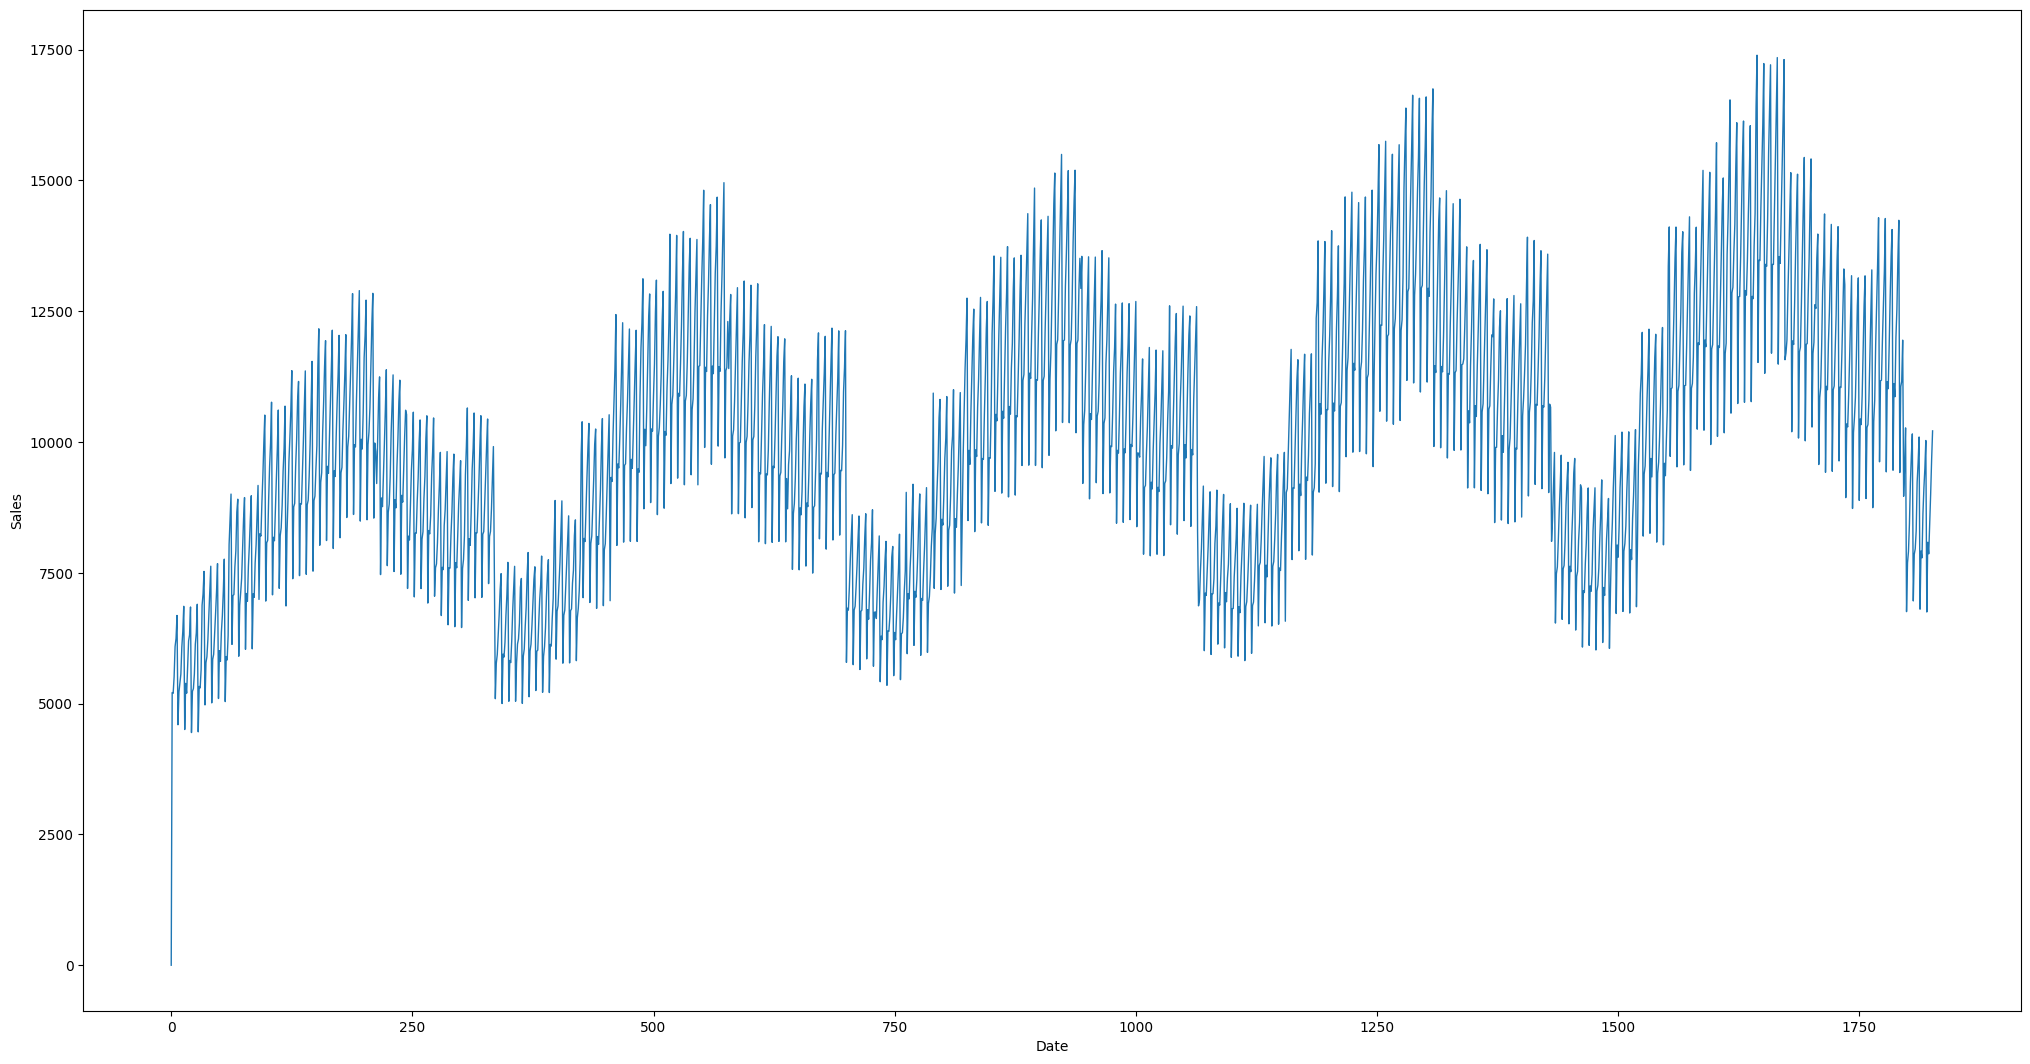

In [ ]:
plt.figure(figsize=(25,13))
plt.plot(daily_sales, linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

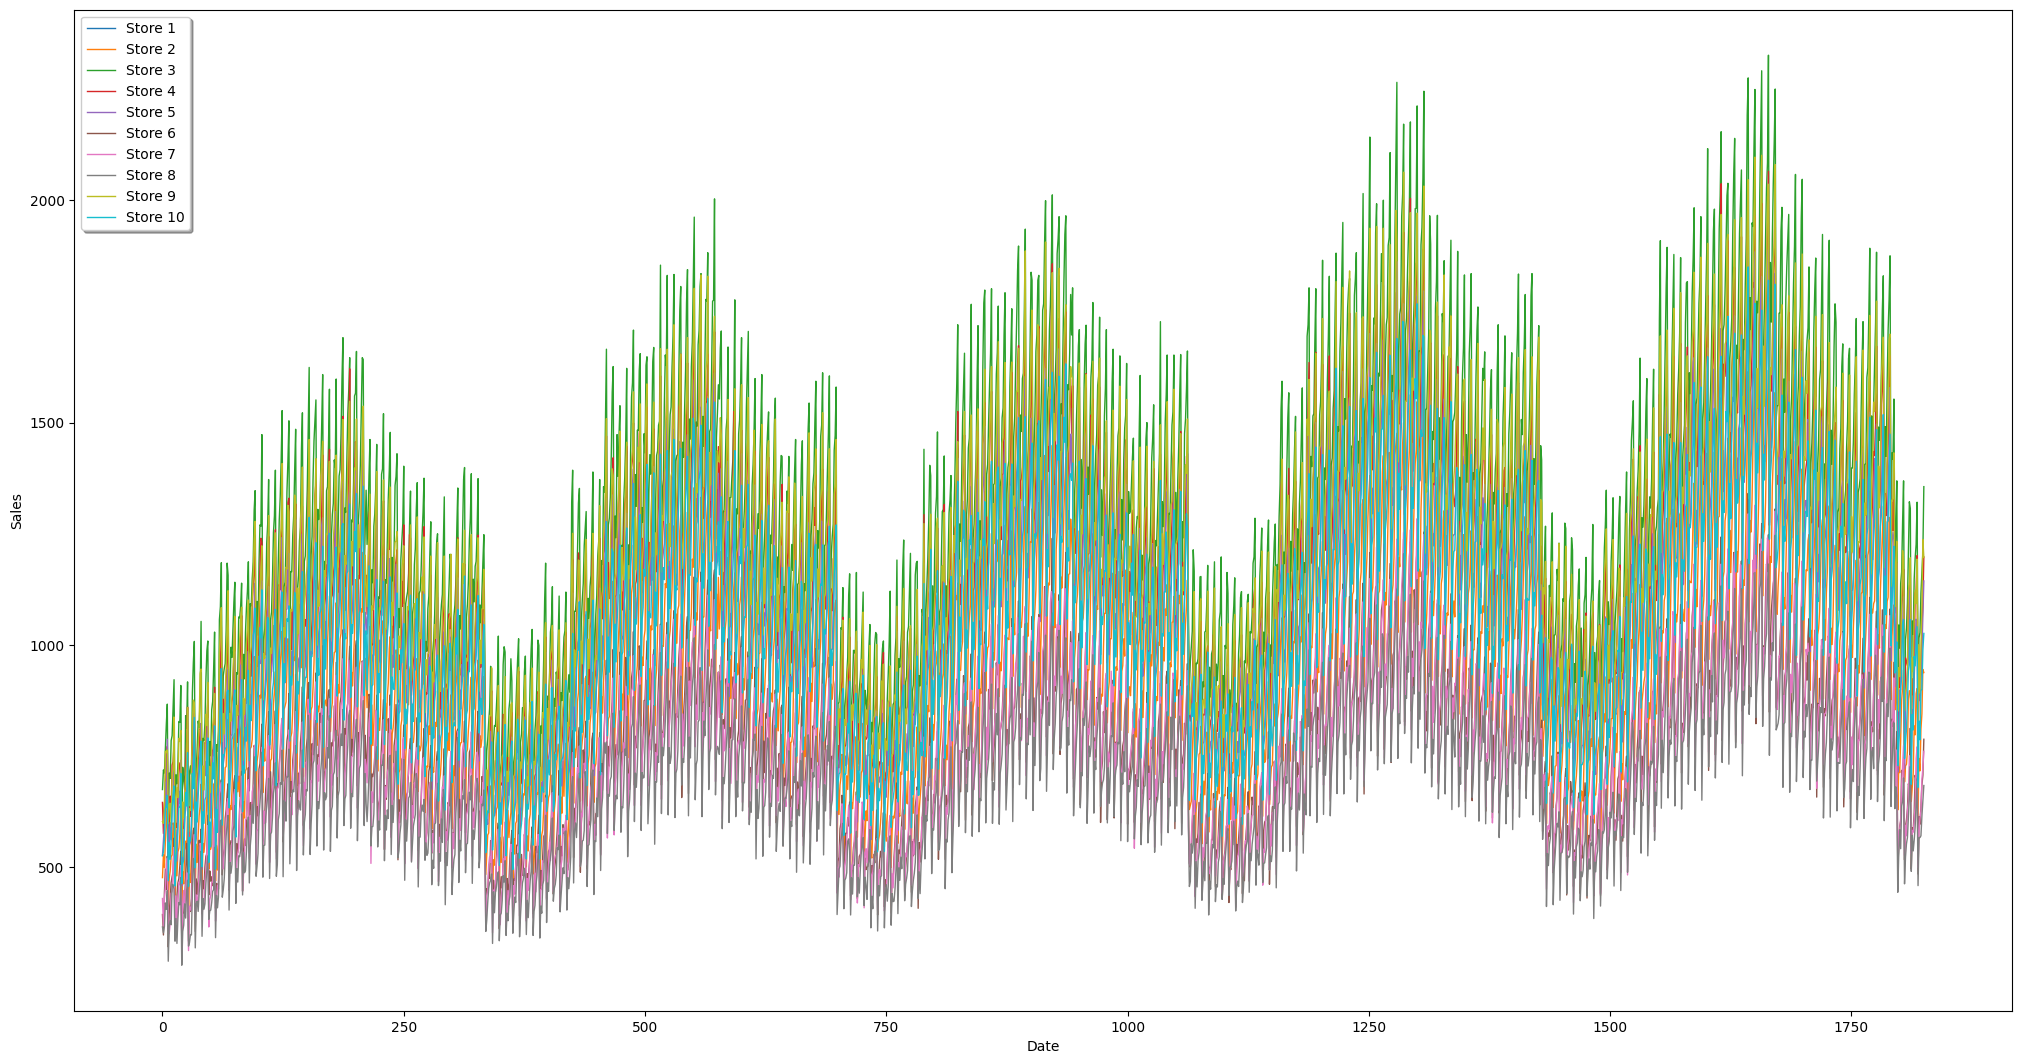

In [ ]:
plt.figure(figsize=(25,13))
legend = []
for i in range(10):
    store_sales=train.loc[train['store'] == i]
    store_sales=store_sales.groupby('date', as_index=False)['sales'].sum()
    store_sales=store_sales.reset_index()['sales']
    plt.plot(store_sales, linewidth=1)
    legend.append(('Store '+str(i+1)))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(legend, loc='upper left', ncol=1, fancybox=True, shadow=True)
plt.show()

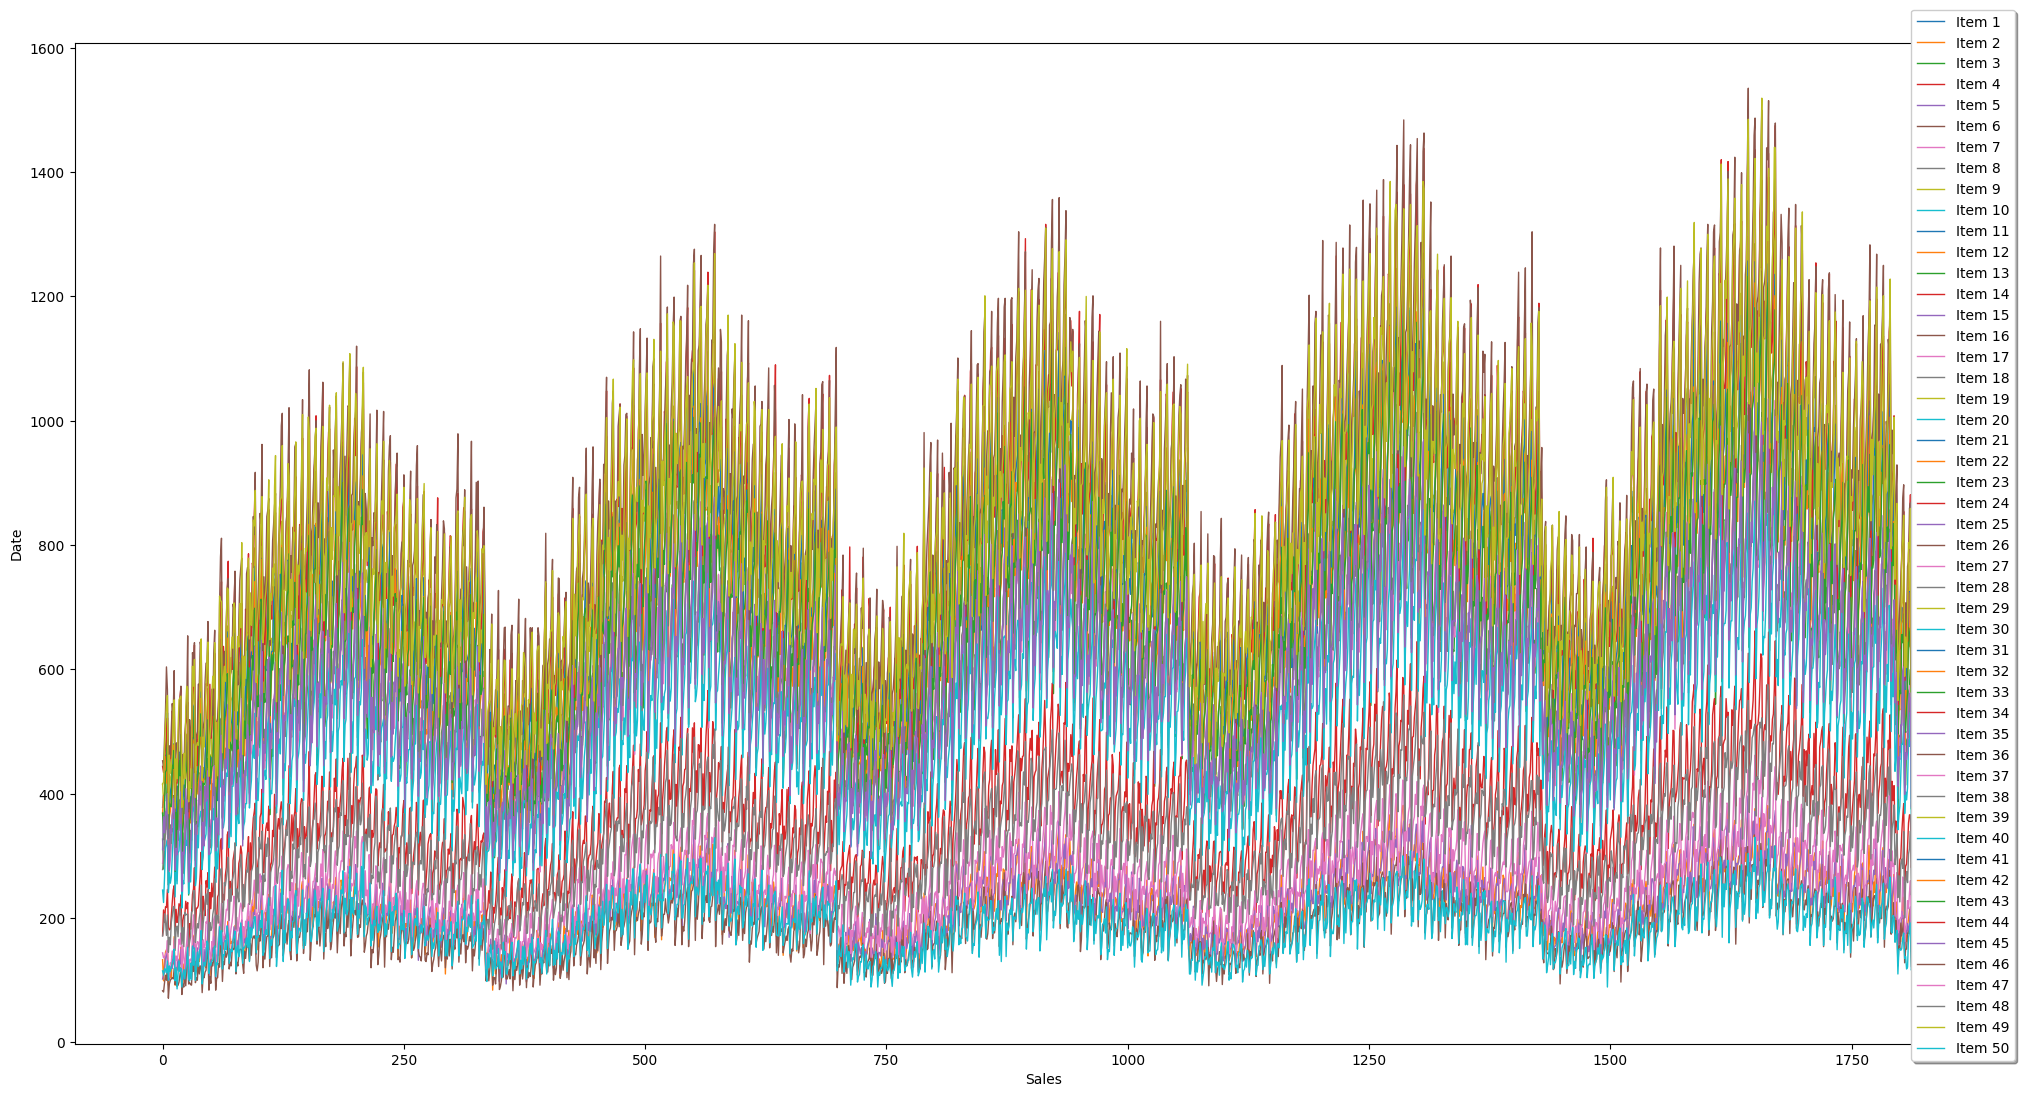

In [ ]:
plt.figure(figsize=(25,13))
legend = []
for i in range(50):
    item_sales=train.loc[train['item'] == i]
    item_sales=item_sales.groupby('date', as_index=False)['sales'].sum()
    item_sales=item_sales.reset_index()['sales']
    plt.plot(item_sales, linewidth=1)
    legend.append(('Item '+str(i+1)))
plt.xlabel('Sales')
plt.ylabel('Date')
plt.legend(legend, loc='upper right', ncol=1, bbox_to_anchor=[1.005, 1.04], fancybox=True, shadow=True)
plt.show()

In [ ]:
train.head()

date  store  item  sales
0  2013-01-01    1.0   1.0   13.0
1  2013-01-02    1.0   1.0   11.0
2  2013-01-03    1.0   1.0   14.0
3  2013-01-04    1.0   1.0   13.0
4  2013-01-05    1.0   1.0   10.0

In [ ]:
train = train[(train['date'] >= '2017-01-01')]
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

item  store        date  sales
0   1.0    1.0  2017-01-01   19.0
1   1.0    1.0  2017-01-02   15.0
2   1.0    1.0  2017-01-03   10.0
3   1.0    1.0  2017-01-04   16.0
4   1.0    1.0  2017-01-05   14.0

In [ ]:
train_gp

item  store        date  sales
0       1.0    1.0  2017-01-01   19.0
1       1.0    1.0  2017-01-02   15.0
2       1.0    1.0  2017-01-03   10.0
3       1.0    1.0  2017-01-04   16.0
4       1.0    1.0  2017-01-05   14.0
...     ...    ...         ...    ...
67155  19.0    4.0  2017-12-27   40.0
67156  19.0    4.0  2017-12-28   33.0
67157  19.0    4.0  2017-12-29   44.0
67158  19.0    4.0  2017-12-30   46.0
67159  19.0    4.0  2017-12-31   38.0

[67160 rows x 4 columns]

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

item(t-29)  store(t-29)  sales(t-29)  item(t-28)  store(t-28)  \
29         1.0          1.0         19.0         1.0          1.0   
30         1.0          1.0         15.0         1.0          1.0   
31         1.0          1.0         10.0         1.0          1.0   
32         1.0          1.0         16.0         1.0          1.0   
33         1.0          1.0         14.0         1.0          1.0   

    sales(t-28)  item(t-27)  store(t-27)  sales(t-27)  item(t-26)  ...  \
29         15.0         1.0          1.0         10.0         1.0  ...   
30         10.0         1.0          1.0         16.0         1.0  ...   
31         16.0         1.0          1.0         14.0         1.0  ...   
32         14.0         1.0          1.0         24.0         1.0  ...   
33         24.0         1.0          1.0         14.0         1.0  ...   

    sales(t-2)  item(t-1)  store(t-1)  sales(t-1)  item(t)  store(t)  \
29        16.0        1.0         1.0        24.0      1.0       1.0   
30        24.0        1.0         1.0         9.0      1.0       1.0   
31         9.0        1.0         1.0        17.0      1.0       1.0   
32        17.0        1.0         1.0        15.0      1.0       1.0   
33        15.0        1.0         1.0        17.0      1.0       1.0   

    sales(t)  item(t+90)  store(t+90)  sales(t+90)  
29       9.0         1.0          1.0         33.0  
30      17.0         1.0          1.0         15.0  
31      15.0         1.0          1.0         21.0  
32      17.0         1.0          1.0         29.0  
33      24.0         1.0          1.0         19.0  

[5 rows x 93 columns]

In [ ]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [ ]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [ ]:
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=42)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (37040, 30)
Validation set shape (24694, 30)


sales(t-29)  sales(t-28)  sales(t-27)  sales(t-26)  sales(t-25)  \
52846         94.0         90.0         95.0         57.0         95.0   
53382         70.0         49.0         66.0         51.0         61.0   
42453         69.0         42.0         45.0         50.0         53.0   
2820          46.0         37.0         45.0         26.0         32.0   
56727         26.0         22.0         28.0         33.0         17.0   

       sales(t-24)  sales(t-23)  sales(t-22)  sales(t-21)  sales(t-20)  ...  \
52846         69.0         85.0         95.0         93.0         99.0  ...   
53382         75.0         54.0         71.0         55.0         50.0  ...   
42453         47.0         66.0         76.0         53.0         50.0  ...   
2820          44.0         37.0         33.0         38.0         39.0  ...   
56727         26.0         23.0         27.0         24.0         31.0  ...   

       sales(t-9)  sales(t-8)  sales(t-7)  sales(t-6)  sales(t-5)  sales(t-4)  \
52846        70.0        83.0        76.0       101.0        49.0        62.0   
53382        70.0        71.0        55.0        66.0        63.0        56.0   
42453        60.0        72.0        36.0        53.0        56.0        49.0   
2820         32.0        31.0        31.0        40.0        27.0        26.0   
56727        25.0        28.0        30.0        26.0        24.0        17.0   

       sales(t-3)  sales(t-2)  sales(t-1)  sales(t)  
52846        65.0        64.0        65.0      86.0  
53382        52.0        90.0        90.0      48.0  
42453        59.0        67.0        71.0      52.0  
2820         37.0        42.0        35.0      37.0  
56727        27.0        27.0        34.0      24.0  

[5 rows x 30 columns]

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (37040, 30, 1)
Validation set shape (24694, 30, 1)


In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=40, verbose=2)

Epoch 1/40
1158/1158 - 25s - loss: 722.3863 - val_loss: 502.8376 - 25s/epoch - 22ms/step
Epoch 2/40
1158/1158 - 24s - loss: 446.6693 - val_loss: 417.4071 - 24s/epoch - 21ms/step
Epoch 3/40
1158/1158 - 22s - loss: 405.0829 - val_loss: 430.5397 - 22s/epoch - 19ms/step
Epoch 4/40
1158/1158 - 25s - loss: 401.5384 - val_loss: 397.9139 - 25s/epoch - 21ms/step
Epoch 5/40
1158/1158 - 22s - loss: 392.9381 - val_loss: 409.3600 - 22s/epoch - 19ms/step
Epoch 6/40
1158/1158 - 28s - loss: 395.2854 - val_loss: 392.6738 - 28s/epoch - 24ms/step
Epoch 7/40
1158/1158 - 22s - loss: 394.4302 - val_loss: 401.7065 - 22s/epoch - 19ms/step
Epoch 8/40
1158/1158 - 23s - loss: 388.4438 - val_loss: 392.0079 - 23s/epoch - 20ms/step
Epoch 9/40
1158/1158 - 21s - loss: 391.3390 - val_loss: 396.2111 - 21s/epoch - 18ms/step
Epoch 10/40
1158/1158 - 22s - loss: 389.9018 - val_loss: 396.1087 - 22s/epoch - 19ms/step
Epoch 11/40
1158/1158 - 22s - loss: 399.9483 - val_loss: 405.1923 - 22s/epoch - 19ms/step
Epoch 12/40
1158/11

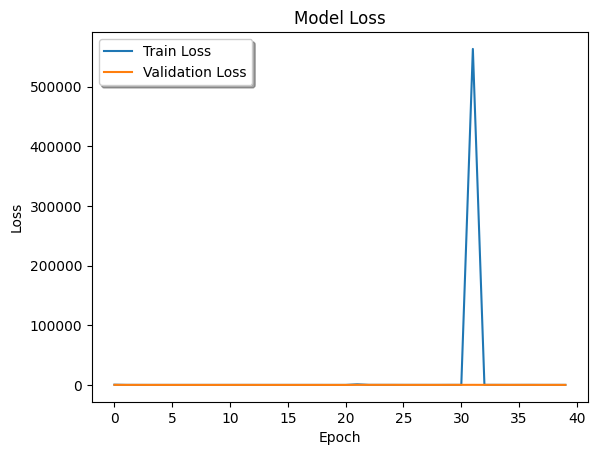

In [ ]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], fancybox=True, shadow=True)
plt.show()

In [ ]:
# Predicting the prices
predicted_sales = model_lstm.predict(X_valid_series)

# # We flatten the 2 dimensional array so we can plot it with matplotlib
Y_valid = Y_valid.flatten()
predicted_sales = predicted_sales.flatten()

772/772 [==============================] - 6s 8ms/step


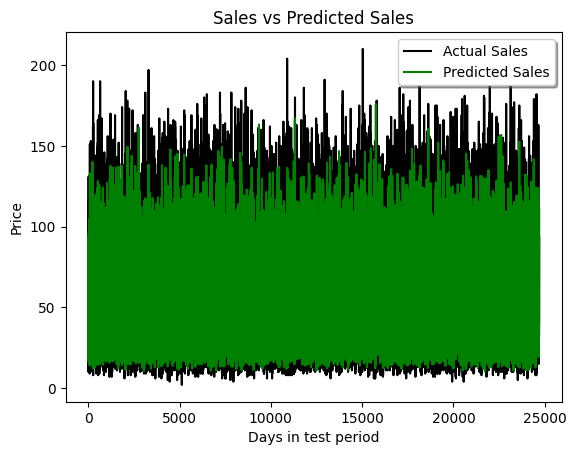

In [ ]:
plt.plot(Y_valid, color='black', label=f"Actual Sales")
plt.plot(predicted_sales, color= 'green', label="Predicted Sales")
plt.title("Sales vs Predicted Sales")
plt.xlabel("Days in test period")
plt.ylabel("Price")
plt.legend(fancybox=True, shadow=True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('train.csv')
display(df.head())
display(df.tail())

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

date  store  item  sales
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82

In [ ]:
df.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

In [ ]:
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"]= parts[0].astype('int')
df["month"]= parts[1].astype('int')
df["day"]= parts[2].astype('int')
df.head()

date  store  item  sales  year  month  day
0  2013-01-01      1     1     13  2013      1    1
1  2013-01-02      1     1     11  2013      1    2
2  2013-01-03      1     1     14  2013      1    3
3  2013-01-04      1     1     13  2013      1    4
4  2013-01-05      1     1     10  2013      1    5

In [ ]:
from datetime import datetime
import calendar

def weekend_or_weekday(year,month,day):

    d = datetime(year,month,day)
    if d.weekday()>4:
        return 1
    else:
        return 0

df['weekend'] = df.apply(lambda x:weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)
df.head()

date  store  item  sales  year  month  day  weekend
0  2013-01-01      1     1     13  2013      1    1        0
1  2013-01-02      1     1     11  2013      1    2        0
2  2013-01-03      1     1     14  2013      1    3        0
3  2013-01-04      1     1     13  2013      1    4        0
4  2013-01-05      1     1     10  2013      1    5        1

In [ ]:
from datetime import date
import holidays

def is_holiday(x):

  india_holidays = holidays.country_holidays('IN')

  if india_holidays.get(x):
    return 1
  else:
    return 0

df['holidays'] = df['date'].apply(is_holiday)
df.head()

date  store  item  sales  year  month  day  weekend  holidays
0  2013-01-01      1     1     13  2013      1    1        0         0
1  2013-01-02      1     1     11  2013      1    2        0         0
2  2013-01-03      1     1     14  2013      1    3        0         0
3  2013-01-04      1     1     13  2013      1    4        0         0
4  2013-01-05      1     1     10  2013      1    5        1         0

In [ ]:
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df.head()

date  store  item  sales  year  month  day  weekend  holidays   m1  \
0  2013-01-01      1     1     13  2013      1    1        0         0  0.5   
1  2013-01-02      1     1     11  2013      1    2        0         0  0.5   
2  2013-01-03      1     1     14  2013      1    3        0         0  0.5   
3  2013-01-04      1     1     13  2013      1    4        0         0  0.5   
4  2013-01-05      1     1     10  2013      1    5        1         0  0.5   

         m2  
0  0.866025  
1  0.866025  
2  0.866025  
3  0.866025  
4  0.866025

In [ ]:
def which_day(year, month, day):

    d = datetime(year,month,day)
    return d.weekday()

df['weekday'] = df.apply(lambda x: which_day(x['year'],
                                                      x['month'],
                                                      x['day']),
                                   axis=1)
df.head()

date  store  item  sales  year  month  day  weekend  holidays   m1  \
0  2013-01-01      1     1     13  2013      1    1        0         0  0.5   
1  2013-01-02      1     1     11  2013      1    2        0         0  0.5   
2  2013-01-03      1     1     14  2013      1    3        0         0  0.5   
3  2013-01-04      1     1     13  2013      1    4        0         0  0.5   
4  2013-01-05      1     1     10  2013      1    5        1         0  0.5   

         m2  weekday  
0  0.866025        1  
1  0.866025        2  
2  0.866025        3  
3  0.866025        4  
4  0.866025        5

In [ ]:
df.drop('date', axis=1, inplace=True)

In [ ]:
df['store'].nunique(), df['item'].nunique()

(10, 50)

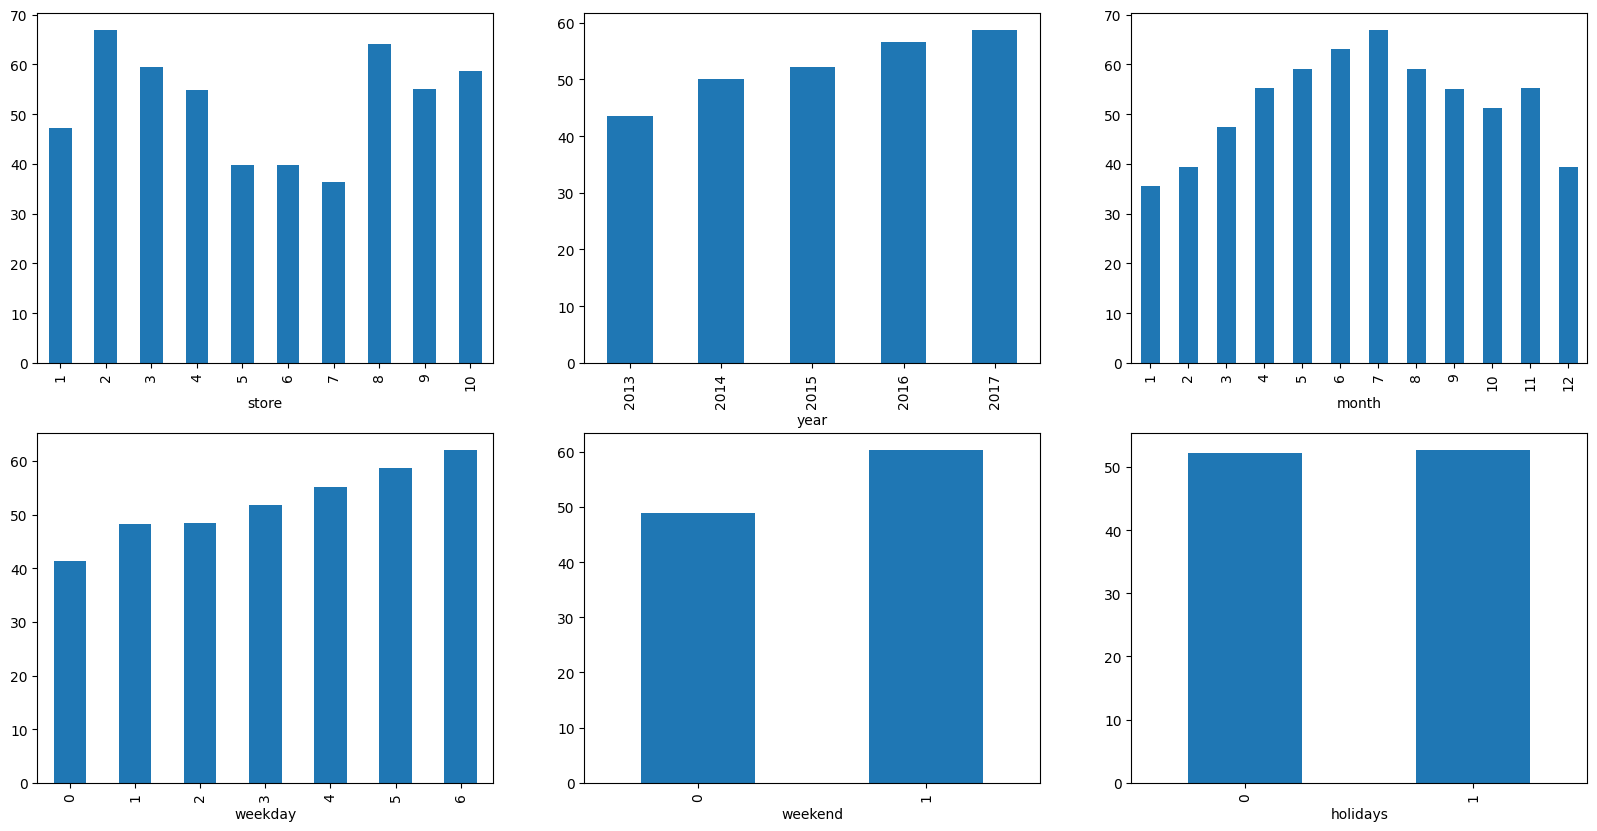

In [ ]:
features = ['store', 'year', 'month',
			'weekday', 'weekend', 'holidays']
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
	plt.subplot(2, 3, i + 1)
	df.groupby(col).mean()['sales'].plot.bar()
plt.show()

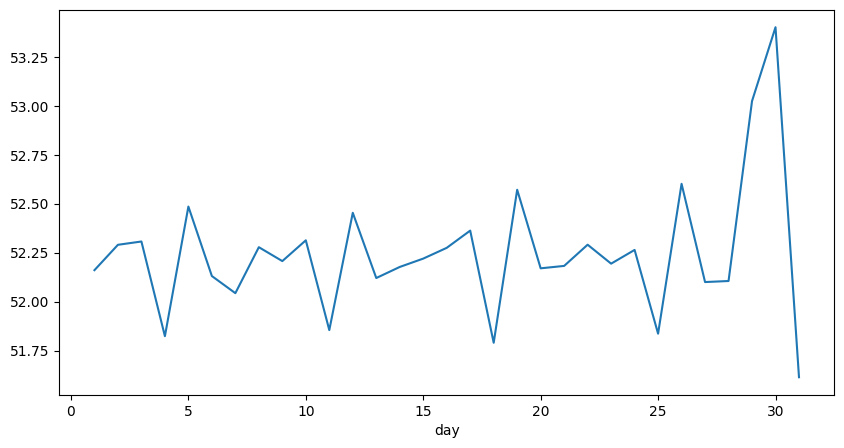

In [ ]:
plt.figure(figsize=(10,5))
df.groupby('day').mean()['sales'].plot()
plt.show()

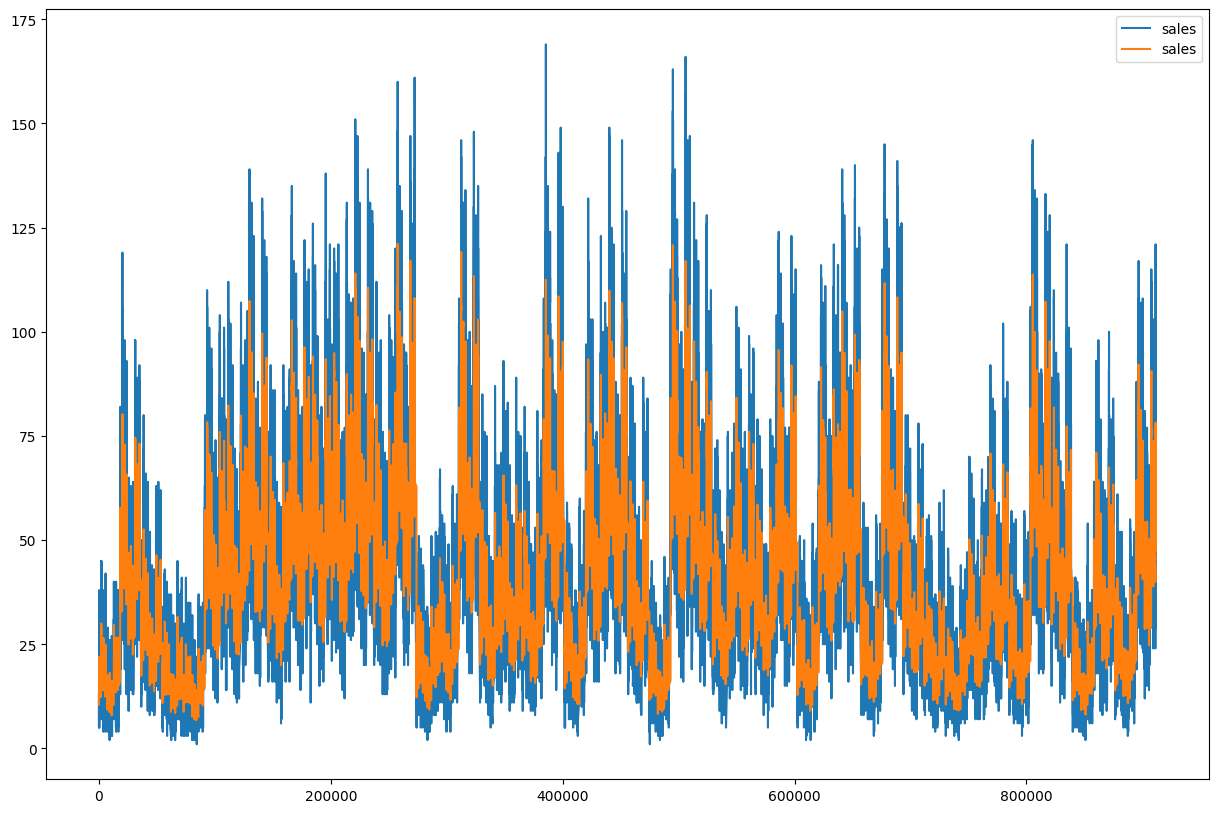

In [ ]:
plt.figure(figsize=(15, 10))

# Calculating Simple Moving Average
# for a window period of 30 days
window_size = 30
data = df[df['year']==2013]
windows = data['sales'].rolling(window_size)
sma = windows.mean()
sma = sma[window_size - 1:]

data['sales'].plot()
sma.plot()
plt.legend()
plt.show()

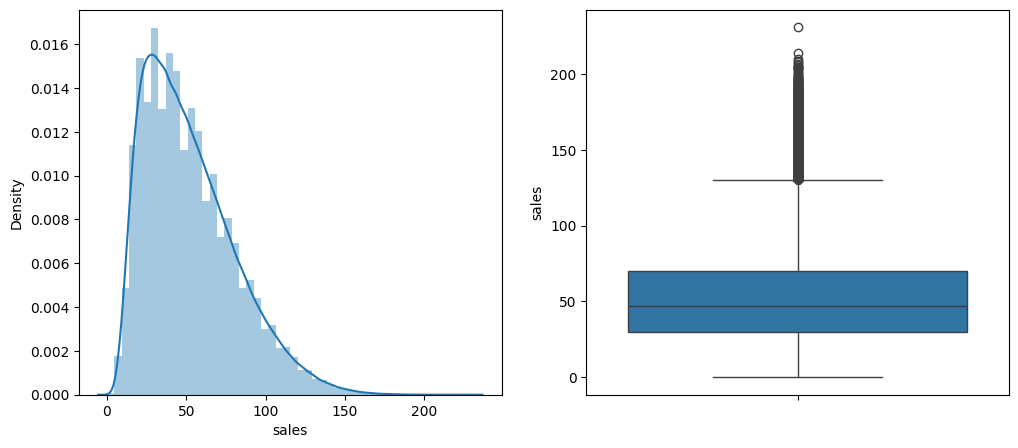

In [ ]:
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.distplot(df['sales'])

plt.subplot(1, 2, 2)
sb.boxplot(df['sales'])
plt.show()

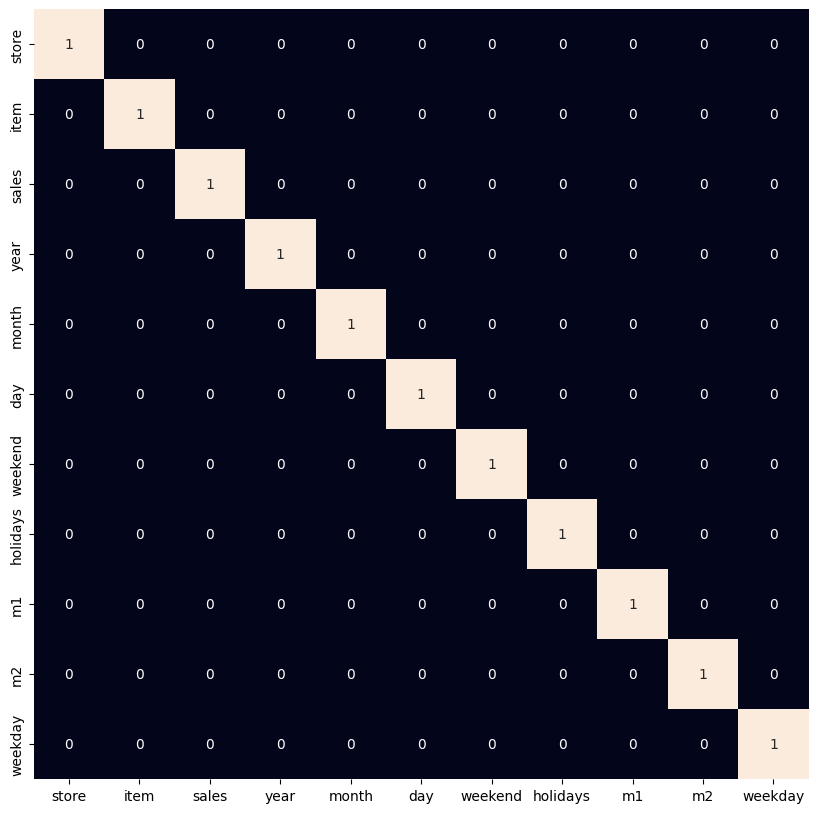

In [ ]:
plt.figure(figsize=(10, 10))
sb.heatmap(df.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()

In [ ]:
df = df[df['sales']<140]

In [ ]:
features = df.drop(['sales', 'year'], axis=1)
target = df['sales'].values


X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                                  test_size = 0.05,
                                                  random_state=22)
X_train.shape, X_val.shape

((861170, 9), (45325, 9))

In [ ]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge()]

for i in range(4):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')

    train_preds = models[i].predict(X_train)
    print('Training Error : ', mae(Y_train, train_preds))

    val_preds = models[i].predict(X_val)
    print('Validation Error : ', mae(Y_val, val_preds))
    print()

LinearRegression() : 
Training Error :  20.902989838083602
Validation Error :  20.97163963254154

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Error :  6.902142131234314
Validation Error :  6.9201690247120675

Lasso() : 
Training Error :  21.015028699769758
Validation Error :  21.07151